In [1]:
import os              
os.environ['PYTHONHASHSEED'] = '0'
import pandas as pd                                                    
import numpy as np                                                     
import scanpy as sc                                                                                 
from time import time                                                       
import sys
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from anndata import concat
from anndata import AnnData, read_h5ad
import warnings
%matplotlib inline

warnings.filterwarnings('ignore')
# sc.settings.set_figure_params(dpi=300)

In [2]:
adata = read_h5ad("merscope_integrated_855_raw.h5ad")

In [24]:
def sample_qc(adata_tot):
    cell_pct_lst = []
    cell_umi_lst = []
    cell_volume_lst = []
    source_uniq = np.unique(adata_tot.obs['source'])
    for i in tqdm(range(len(source_uniq))):
        adata = adata_tot[adata_tot.obs['source'] == source_uniq[i]].copy()
        cell_pct = (np.sum(adata.X != 0, axis=1)/adata.shape[1])
        cell_umi = np.sum(adata.X, axis=1)
        cell_umi = np.array(cell_umi)
        cell_volume = adata.obs[["volume"]].values
        cell_pct[cell_pct > np.quantile(cell_pct, 0.98)] = np.quantile(cell_pct, 0.98)
        cell_umi[cell_umi > np.quantile(cell_umi, 0.98)] = np.quantile(cell_umi, 0.98)
        cell_volume[cell_volume > np.quantile(cell_volume, 0.98)] = np.quantile(cell_volume, 0.98)
        
        cell_pct = pd.DataFrame(cell_pct)
        cell_pct.columns = ["cell_pct"]; cell_pct['source_new'] = source_uniq[i]
        
        cell_umi = pd.DataFrame(cell_umi)
        cell_umi.columns = ["cell_umi"]; cell_umi['source_new'] = source_uniq[i]
        
        cell_volume = pd.DataFrame(cell_volume)
        cell_volume.columns = ["cell_volume"]; cell_volume['source_new'] = source_uniq[i]
        
        cell_pct_lst.append(cell_pct)
        cell_umi_lst.append(cell_umi)
        cell_volume_lst.append(cell_volume)
    return cell_pct_lst, cell_umi_lst, cell_volume_lst

In [25]:
cell_pct_lst, cell_umi_lst, cell_volume_lst = sample_qc(adata_tot=adata)
cell_pct_df = pd.concat(cell_pct_lst, axis=0)
cell_umi_df = pd.concat(cell_umi_lst, axis=0)
cell_volume_df = pd.concat(cell_volume_lst, axis=0)

100%|██████████| 39/39 [00:23<00:00,  1.68it/s]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


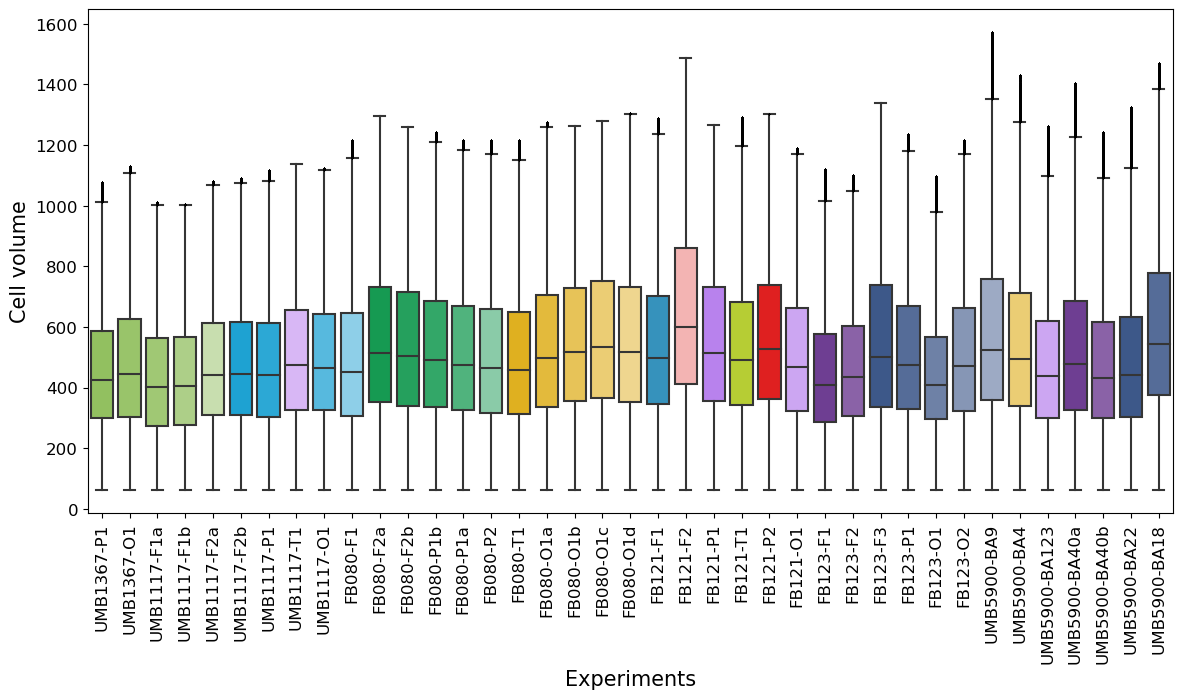

In [ ]:
h2_colors = ['#92D050','#99D35B','#A0D666','#ADDB7C','#C8E6A7','#00B0F0','#10B5F1','#D8ADFF','#40C3F4','#7FD6F7','#00B050','#10B55B','#20BA66','#40C37C','#7FD6A7','#FFC000','#FFC820','#FFCF40','#FFD760','#FFDE7F','#209AD2','#FEAAA8','#B870FF','#C8E61B','#FF0000'
             ,'#CC99FF','#7030A0','#8C57B2','#305496','#4A69A3','#647EB0','#7E93BD','#97A8CA', '#FFD760', '#CC99FF', '#7030A0', '#8C57B2', '#305496', '#4A69A3']
order = ["UMB1367-P1", "UMB1367-O1", "UMB1117-F1a", "UMB1117-F1b", "UMB1117-F2a", 
             "UMB1117-F2b", "UMB1117-P1", "UMB1117-T1", "UMB1117-O1", "FB080-F1", 
             "FB080-F2a", "FB080-F2b", "FB080-P1b", "FB080-P1a", "FB080-P2", 
             "FB080-T1", "FB080-O1a", "FB080-O1b", "FB080-O1c", "FB080-O1d", 
             "FB121-F1", "FB121-F2", "FB121-P1", "FB121-T1", "FB121-P2", 
             "FB121-O1", "FB123-F1", "FB123-F2", "FB123-F3", "FB123-P1", 
             "FB123-O1", "FB123-O2", "UMB5900-BA9", "UMB5900-BA4", "UMB5900-BA123", 
             "UMB5900-BA40a", "UMB5900-BA40b", "UMB5900-BA22", "UMB5900-BA18"]
h2_dict = dict(zip(order, h2_colors))
flierprops = dict(marker='s', markerfacecolor='None', markersize=0.1,  markeredgecolor='black')

fig = plt.figure(figsize=(14, 8))
plot = sns.boxplot(data=cell_volume_df, x='source_new', y='cell_volume', palette=h2_dict, order=order, flierprops=flierprops )
plot.legend().remove(); plt.xticks(rotation=90, fontsize=12); plt.yticks(fontsize=12); plot.set(xlabel=None)
plot.set_ylabel('Cell volume', fontsize=15)
plot.set_xlabel('Experiments', fontsize=15)
fig.subplots_adjust(bottom=0.25)
plt.savefig('box_volume_experiment.pdf', format = "pdf", dpi=500, bbox_to_inches = 'tight')
# plt.close()

In [28]:
def cluster_qc(adata_tot):
    # cluster_lst = []
    cell_pct_lst = []
    cell_umi_lst = []
    cell_volume_lst = []
    cluster_uniq = np.unique(adata_tot.obs['H2_annotation'])
    for i in tqdm(range(len(cluster_uniq))):
        adata_cluster = adata_tot[adata_tot.obs['H2_annotation'] == cluster_uniq[i]]

        cell_pct = (np.sum(adata_cluster.X != 0, axis=1)/adata_cluster.shape[1])
        cell_umi = np.sum(adata_cluster.X, axis=1)
        cell_volume = adata_cluster.obs[["volume"]].values
        cell_pct[cell_pct > np.quantile(cell_pct, 0.98)] = np.quantile(cell_pct, 0.98)
        cell_umi[cell_umi > np.quantile(cell_umi, 0.98)] = np.quantile(cell_umi, 0.98)
        cell_volume[cell_volume > np.quantile(cell_volume, 0.98)] = np.quantile(cell_volume, 0.98)
        
        cell_pct = pd.DataFrame(cell_pct)
        cell_pct.columns = ["cell_pct"]; cell_pct['source_new'] = cluster_uniq[i]
        
        cell_umi = pd.DataFrame(cell_umi)
        cell_umi.columns = ["cell_umi"]; cell_umi['source_new'] = cluster_uniq[i]
        
        cell_volume = pd.DataFrame(cell_volume)
        cell_volume.columns = ["cell_volume"]; cell_volume['source_new'] = cluster_uniq[i]
        
        cell_pct_lst.append(cell_pct)
        cell_umi_lst.append(cell_umi)
        cell_volume_lst.append(cell_volume)
    return cell_pct_lst, cell_umi_lst, cell_volume_lst

In [ ]:
cell_pct_lst_h2, cell_umi_lst_h2, cell_volume_lst_h2 = cluster_qc(adata_tot=adata)
cell_pct_df = pd.concat(cell_pct_lst_h2, axis=0)
cell_umi_df = pd.concat(cell_umi_lst_h2, axis=0)
cell_volume_df = pd.concat(cell_volume_lst_h2, axis=0)

100%|██████████| 33/33 [00:21<00:00,  1.56it/s]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


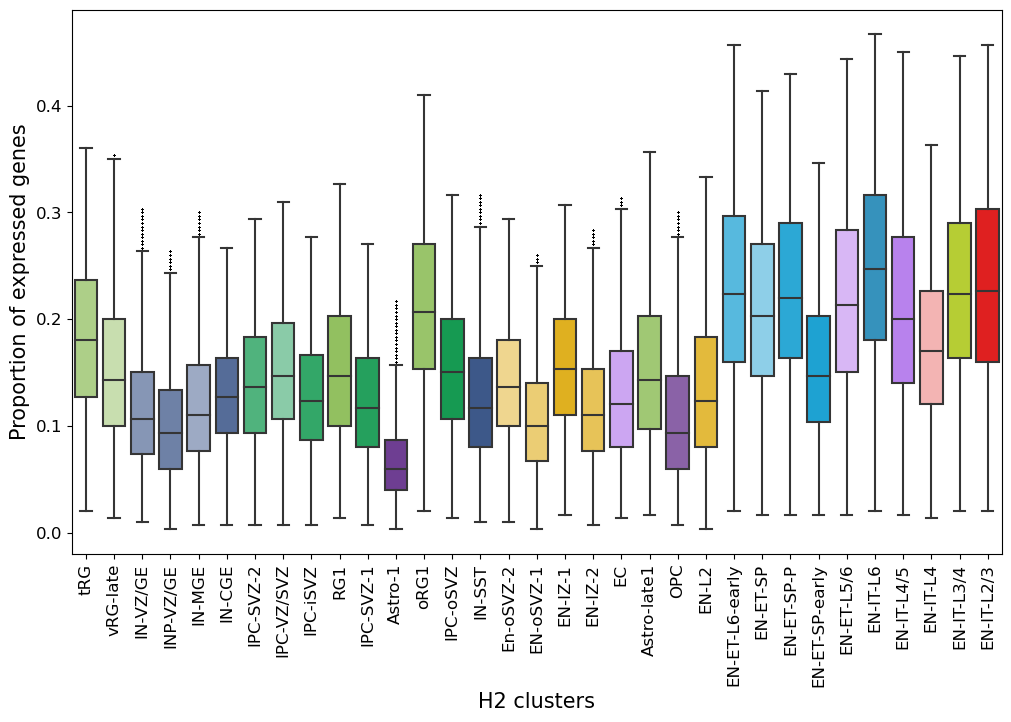

In [32]:
h2_colors = ['#92D050','#99D35B','#A0D666','#ADDB7C','#C8E6A7','#00B0F0','#10B5F1','#D8ADFF','#40C3F4','#7FD6F7','#00B050','#10B55B','#20BA66','#40C37C','#7FD6A7','#FFC000','#FFC820','#FFCF40','#FFD760','#FFDE7F','#209AD2','#FEAAA8','#B870FF','#C8E61B','#FF0000','#CC99FF','#7030A0','#8C57B2','#305496','#4A69A3','#647EB0','#7E93BD','#97A8CA']
h2_types = ['RG1', 'oRG1','Astro-late1','tRG','vRG-late',"EN-ET-SP-early",'EN-ET-SP-P','EN-ET-L5/6','EN-ET-L6-early','EN-ET-SP','IPC-oSVZ','IPC-SVZ-1','IPC-iSVZ', 'IPC-SVZ-2', 'IPC-VZ/SVZ','EN-IZ-1','EN-L2','EN-IZ-2','EN-oSVZ-1','En-oSVZ-2','EN-IT-L6','EN-IT-L4','EN-IT-L4/5','EN-IT-L3/4','EN-IT-L2/3','EC','Astro-1', 'OPC','IN-SST', 'IN-CGE', 'INP-VZ/GE', 'IN-VZ/GE', 'IN-MGE']
h2_dict = dict(zip(h2_types, h2_colors))
order = ['tRG','vRG-late','IN-VZ/GE','INP-VZ/GE','IN-MGE','IN-CGE','IPC-SVZ-2', 'IPC-VZ/SVZ','IPC-iSVZ','RG1','IPC-SVZ-1','Astro-1','oRG1','IPC-oSVZ','IN-SST','En-oSVZ-2','EN-oSVZ-1','EN-IZ-1','EN-IZ-2','EC','Astro-late1','OPC','EN-L2','EN-ET-L6-early','EN-ET-SP','EN-ET-SP-P',"EN-ET-SP-early",'EN-ET-L5/6','EN-IT-L6','EN-IT-L4/5','EN-IT-L4','EN-IT-L3/4','EN-IT-L2/3']

flierprops = dict(marker='s', markerfacecolor='None', markersize=0.1,  markeredgecolor='black')

fig = plt.figure(figsize=(12, 8))
plot = sns.boxplot(data=cell_pct_df, x='source_new', y='cell_pct', order=order, palette=h2_dict, flierprops=flierprops )
plot.legend().remove(); plt.xticks(rotation=90, fontsize=12); plt.yticks(fontsize=12); plot.set(xlabel=None) 
# plt.ylim((0,1))
plot.set_ylabel('Proportion of expressed genes', fontsize=15)
plot.set_xlabel('H2 clusters', fontsize=15)
fig.subplots_adjust(bottom=0.2)
plt.savefig('box_prop.pdf', format = "pdf", dpi=500, bbox_to_inches = 'tight')
# plt.close()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


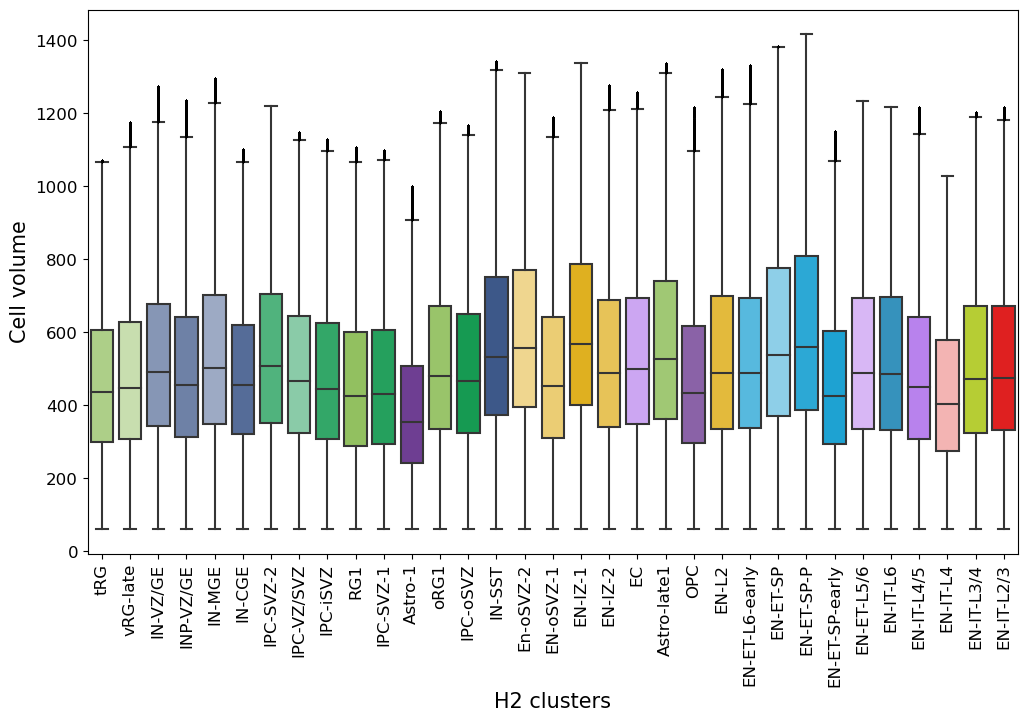

In [ ]:
fig = plt.figure(figsize=(12, 8))
plot = sns.boxplot(data=cell_volume_df, x='source_new', y='cell_volume', order=order, palette=h2_dict, flierprops=flierprops )
plot.legend().remove(); plt.xticks(rotation=90, fontsize=12); plt.yticks(fontsize=12); plot.set(xlabel=None) 
# plt.ylim((0,1))
plot.set_ylabel('Cell volume', fontsize=15)
plot.set_xlabel('H2 clusters', fontsize=15)
fig.subplots_adjust(bottom=0.2)
plt.savefig('box_volume.pdf', format = "pdf", dpi=500, bbox_to_inches = 'tight')
# plt.close()